
---
# Implementation of **Value Iteration**, **Policy Iteration** and **Modified Policy Iteration(MDP)** algorithms.

The following is the MDP.py implementation from the sceleton code in A1 part 1.

---


In [ ]:
import numpy as np


class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self, T, R, discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (
        self.nActions, self.nStates, self.nStates), "Invalid transition function: it has dimensionality " + repr(
            T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(
            2) - 1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions"
        assert R.shape == (self.nActions, self.nStates), "Invalid reward function: it has dimensionality " + repr(
            R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        V = initialV
        iterId = 0
        epsilon = np.inf
        policy = np.zeros(len(initialV), dtype=int)

        """
        print("===========================================================================")
        print("Executing Value Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations and epsilon > tolerance:
            Ta_V = np.matmul(self.T, V)
            gamma_Ta_V = self.discount * Ta_V
            all_possible_values = self.R + gamma_Ta_V
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep
            V_new = np.amax((all_possible_values), axis=0)  # Choose the best action values for each state
            # np.round/np.around does not work for 0.5 so not reducing to 2 decimal places
            V_diff = (V_new - V)
            V = V_new
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon: " + str(epsilon))
            iterId = iterId + 1

        """
        print("--------------------------------------------")
        print("Final State values after " + str(iterId) + " iterations , V: " + str(V) + " Policy: " + str(policy))
        print("===========================================================================")
        """

        return [V, iterId, epsilon]

    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Extraction")
        print("--------------------------------------------")
        """

        all_possible_values = (self.R + (self.discount*(np.matmul(self.T, V))))  # Get values for all possible state transition in this state

        """
        print("All Values for All possible state transition: ")
        print(all_possible_values)
        """

        policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

        """
        print("Extracted Policy : " + str(policy))
        print("--------------------------------------------")
        """

        """
        # track of action chosen at timestamp t, instead of choosing only value
        max_values = [all_possible_values[policy[i]][i] for i in range(len(policy))]
        print("Values Corresponding to Selected Policies: " + str(max_values))
        print("***************************************************************")
        """

        return policy

    def evaluatePolicy(self, policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by solving a system of linear equations")
        """

        R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
        T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
        gamma_T_policy = self.discount * T_policy
        assert gamma_T_policy.shape[0] == gamma_T_policy.shape[1], "gamma_T_policy matrix should be square"
        V = np.matmul(np.linalg.inv(np.identity(len(policy)) - gamma_T_policy), R_policy)

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return V

    def policyIteration(self, initialPolicy, nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar'''

        policy = initialPolicy  # np.zeros(self.nStates)
        V = np.zeros(self.nStates)
        iterId = 0

        """
        print("===========================================================================")
        print("Executing Policy Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations:
            V = self.evaluatePolicy(policy)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))

            policy_new = self.extractPolicy(V)
            iterId = iterId + 1

            if np.array_equal(policy_new, policy):
                break

            policy = policy_new

        """
        print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId]

    def evaluatePolicyPartially(self, policy, initialV, nIterations=np.inf, tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV  # np.zeros(self.nStates)
        iterId = 0
        epsilon = np.inf

        """
        print("***************************************************************")
        print("Executing Partial Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by repeating " + str(nIterations) + " times.")
        print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId+1
            R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
            T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
            Vnew = R_policy + (self.discount * np.matmul(T_policy, V))
            epsilon = np.linalg.norm((Vnew-V), np.inf)
            V = Vnew

            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon : " + str(epsilon))

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return [V, iterId, epsilon]

    def modifiedPolicyIteration(self, initialPolicy, initialV, nEvalIterations=5, nIterations=np.inf, tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf

        """
        print("===========================================================================")
        print("Executing Modified Policy Iteration")
        print("--------------------------------------------")
        print("Iteration : " + str(iterId) + " policy : " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId + 1
            Vn, _ , _  = self.evaluatePolicyPartially(policy, V, nEvalIterations, tolerance)
            #print("Vn : " + str(Vn))
            all_possible_values = (self.R + (self.discount * np.matmul(self.T,Vn)))  # Get values for all possible state transition in this state
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

            Vn_plus_1 = [all_possible_values[policy[i]][i] for i in range(len(policy))]
            V_diff = (Vn_plus_1 - Vn)
            V = Vn_plus_1
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " policy : " + str(policy))

        """
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId, epsilon]


## Testing value iteration, policy iteration and modified policy iteration for Markov decision processes with provided example
---

The following is the TestMDP.py file to test out the the simple MDP example from Lecture 1b Slides 17-18.

---


In [ ]:
''' Construct simple MDP as described in Lecture 1b Slides 17-18'''
# Transition function: |A| x |S| x |S'| array
T = np.array([[[0.5,0.5,0,0],[0,1,0,0],[0.5,0.5,0,0],[0,1,0,0]],[[1,0,0,0],[0.5,0,0,0.5],[0.5,0,0.5,0],[0,0,0.5,0.5]]])
# Reward function: |A| x |S| array
R = np.array([[0,0,10,10],[0,0,10,10]])
# Discount factor: scalar in [0,1)
discount = 0.9        
# MDP object
mdp = MDP(T,R,discount)


---

Testing valueIteration & extractPolicy procedure using simple MDP example from Lecture 1b Slides 17-18.

---


In [ ]:
'''Test each procedure'''
[V,nIterations,epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates))
policy = mdp.extractPolicy(V)
print("V : " + str(V))
print("nIterations : " + str(nIterations))
print("Policy : " + str(policy))

V : [31.49636306 38.51527513 43.935435   54.1128575 ]
nIterations : 58
Policy : [0 1 1 1]



---


Testing evaluatePolicy procedure using simple MDP example from Lecture 1b Slides 17-18. We see the results from evaluatePolicy match from the previous valueIteration and extractPolicy procedures

---


In [ ]:
V = mdp.evaluatePolicy(np.array([1,0,1,0]))
print("Value corresponding to policy [1,0,1,0]: " + str(V))

V = mdp.evaluatePolicy(np.array([0,1,1,1]))
print("Value corresponding to policy [0,1,1,1]: " + str(V))

Value corresponding to policy [1,0,1,0]: [ 0.          0.         18.18181818 10.        ]
Value corresponding to policy [0,1,1,1]: [31.58510431 38.60401638 44.02417625 54.20159875]



---

Testing policyIteration procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---


In [ ]:
[policy,V,iterId] = mdp.policyIteration(np.array([0,0,0,0]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Epsilon : " + str(policy))

V : [31.58510431 38.60401638 44.02417625 54.20159875]
nIterations : 2
Epsilon : [0 1 1 1]



---

Testing modifiedPolicyIteration(MDP) procedure using simple MDP example from Lecture 1b Slides 17-18. We see that the policy result and value results match the valueIteration procedure.

---



In [ ]:
[V,iterId,epsilon] = mdp.evaluatePolicyPartially(np.array([1,0,1,0]),np.array([0,10,0,13]))
[policy,V,iterId,tolerance] = mdp.modifiedPolicyIteration(np.array([1,0,1,0]),np.array([0,10,0,13]))
print("V : " + str(V))
print("nIterations : " + str(iterId))
print("Policy : " + str(policy))

V : [31.50605365934906, 38.524965727978426, 43.945125603197766, 54.12254810271034]
nIterations : 11
Policy : [0 1 1 1]




---

## **Maze Problem** solving using value iteration, policy iteration and modified policy iteration.

---


In [ ]:
import numpy as np

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4, 17, 17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0, 0, 0] = a + b;
T[0, 0, 1] = b;

T[0, 1, 0] = b;
T[0, 1, 1] = a;
T[0, 1, 2] = b;

T[0, 2, 1] = b;
T[0, 2, 2] = a;
T[0, 2, 3] = b;

T[0, 3, 2] = b;
T[0, 3, 3] = a + b;

T[0, 4, 4] = b;
T[0, 4, 0] = a;
T[0, 4, 5] = b;

T[0, 5, 4] = b;
T[0, 5, 1] = a;
T[0, 5, 6] = b;

T[0, 6, 5] = b;
T[0, 6, 2] = a;
T[0, 6, 7] = b;

T[0, 7, 6] = b;
T[0, 7, 3] = a;
T[0, 7, 7] = b;

T[0, 8, 8] = b;
T[0, 8, 4] = a;
T[0, 8, 9] = b;

T[0, 9, 8] = b;
T[0, 9, 5] = a;
T[0, 9, 10] = b;

T[0, 10, 9] = b;
T[0, 10, 6] = a;
T[0, 10, 11] = b;

T[0, 11, 10] = b;
T[0, 11, 7] = a;
T[0, 11, 11] = b;

T[0, 12, 12] = b;
T[0, 12, 8] = a;
T[0, 12, 13] = b;

T[0, 13, 12] = b;
T[0, 13, 9] = a;
T[0, 13, 14] = b;

T[0, 14, 16] = 1;

T[0, 15, 11] = a;
T[0, 15, 14] = b;
T[0, 15, 15] = b;

T[0, 16, 16] = 1;

# down (a = 1)

T[1, 0, 0] = b;
T[1, 0, 4] = a;
T[1, 0, 1] = b;

T[1, 1, 0] = b;
T[1, 1, 5] = a;
T[1, 1, 2] = b;

T[1, 2, 1] = b;
T[1, 2, 6] = a;
T[1, 2, 3] = b;

T[1, 3, 2] = b;
T[1, 3, 7] = a;
T[1, 3, 3] = b;

T[1, 4, 4] = b;
T[1, 4, 8] = a;
T[1, 4, 5] = b;

T[1, 5, 4] = b;
T[1, 5, 9] = a;
T[1, 5, 6] = b;

T[1, 6, 5] = b;
T[1, 6, 10] = a;
T[1, 6, 7] = b;

T[1, 7, 6] = b;
T[1, 7, 11] = a;
T[1, 7, 7] = b;

T[1, 8, 8] = b;
T[1, 8, 12] = a;
T[1, 8, 9] = b;

T[1, 9, 8] = b;
T[1, 9, 13] = a;
T[1, 9, 10] = b;

T[1, 10, 9] = b;
T[1, 10, 14] = a;
T[1, 10, 11] = b;

T[1, 11, 10] = b;
T[1, 11, 15] = a;
T[1, 11, 11] = b;

T[1, 12, 12] = a + b;
T[1, 12, 13] = b;

T[1, 13, 12] = b;
T[1, 13, 13] = a;
T[1, 13, 14] = b;

T[1, 14, 16] = 1;

T[1, 15, 14] = b;
T[1, 15, 15] = a + b;

T[1, 16, 16] = 1;

# left (a = 2)

T[2, 0, 0] = a + b;
T[2, 0, 4] = b;

T[2, 1, 1] = b;
T[2, 1, 0] = a;
T[2, 1, 5] = b;

T[2, 2, 2] = b;
T[2, 2, 1] = a;
T[2, 2, 6] = b;

T[2, 3, 3] = b;
T[2, 3, 2] = a;
T[2, 3, 7] = b;

T[2, 4, 0] = b;
T[2, 4, 4] = a;
T[2, 4, 8] = b;

T[2, 5, 1] = b;
T[2, 5, 4] = a;
T[2, 5, 9] = b;

T[2, 6, 2] = b;
T[2, 6, 5] = a;
T[2, 6, 10] = b;

T[2, 7, 3] = b;
T[2, 7, 6] = a;
T[2, 7, 11] = b;

T[2, 8, 4] = b;
T[2, 8, 8] = a;
T[2, 8, 12] = b;

T[2, 9, 5] = b;
T[2, 9, 8] = a;
T[2, 9, 13] = b;

T[2, 10, 6] = b;
T[2, 10, 9] = a;
T[2, 10, 14] = b;

T[2, 11, 7] = b;
T[2, 11, 10] = a;
T[2, 11, 15] = b;

T[2, 12, 8] = b;
T[2, 12, 12] = a + b;

T[2, 13, 9] = b;
T[2, 13, 12] = a;
T[2, 13, 13] = b;

T[2, 14, 16] = 1;

T[2, 15, 11] = b;
T[2, 15, 14] = a;
T[2, 15, 15] = b;

T[2, 16, 16] = 1;

# right (a = 3)

T[3, 0, 0] = b;
T[3, 0, 1] = a;
T[3, 0, 4] = b;

T[3, 1, 1] = b;
T[3, 1, 2] = a;
T[3, 1, 5] = b;

T[3, 2, 2] = b;
T[3, 2, 3] = a;
T[3, 2, 6] = b;

T[3, 3, 3] = a + b;
T[3, 3, 7] = b;

T[3, 4, 0] = b;
T[3, 4, 5] = a;
T[3, 4, 8] = b;

T[3, 5, 1] = b;
T[3, 5, 6] = a;
T[3, 5, 9] = b;

T[3, 6, 2] = b;
T[3, 6, 7] = a;
T[3, 6, 10] = b;

T[3, 7, 3] = b;
T[3, 7, 7] = a;
T[3, 7, 11] = b;

T[3, 8, 4] = b;
T[3, 8, 9] = a;
T[3, 8, 12] = b;

T[3, 9, 5] = b;
T[3, 9, 10] = a;
T[3, 9, 13] = b;

T[3, 10, 6] = b;
T[3, 10, 11] = a;
T[3, 10, 14] = b;

T[3, 11, 7] = b;
T[3, 11, 11] = a;
T[3, 11, 15] = b;

T[3, 12, 8] = b;
T[3, 12, 13] = a;
T[3, 12, 12] = b;

T[3, 13, 9] = b;
T[3, 13, 14] = a;
T[3, 13, 13] = b;

T[3, 14, 16] = 1;

T[3, 15, 11] = b;
T[3, 15, 15] = a + b;

T[3, 16, 16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4, 17]);

# set rewards
R[:, 14] = 100;  # goal state
R[:, 9] = -70;  # bad state
R[:, 16] = 0;  # end state

# Discount factor: scalar in [0,1)
discount = 0.95

# MDP object
mdp = MDP(T, R, discount)




---

## Part I.I: Calculating **policy**, **value function** and **number of iterations** needed by **value iteration** in Maze Problem

---
### Testing Parameters

*   Tolerance : 0.01. Used following line in *mdp.valueIteration* procedure
```
#  tolerance=0.01
```
*   Initial Value Function: Zero for all states. Used following line in *mdp.valueIteration* procedure
```
#  initialV=np.zeros(mdp.nStates)
```

---

### Results

1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133 52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
3.   **Number of Iterations** : 26

--- 


In [ ]:
[V, nIterations, epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates), tolerance=0.01)
policy = mdp.extractPolicy(V)

In [ ]:
print("==================================================================")
print("MDPMaze Value Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Value Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.66895295  55.27161487  61.57363146  65.87460207  48.00953133
  52.30188839  68.13923599  73.25481858  50.22617115  -0.42481753
  77.06611566  81.36344171  66.36179067  76.31383816 100.
  89.90583635   0.        ]
Number of Iterations: 26





---

## Part I.II: Calculating **policy**, **value function** and **number of iterations** needed by **policy iteration** in Maze Problem

---

### Testing Parameters

*   Initial Policy: Uses action 0 in all states. Used following line in *mdp.policyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```

---

### Results


1.   **Policy** : [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
2.   **Value Function** : [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
3.   **Number of Iterations** : 7

---



In [ ]:
[policy, V, nIterations] = mdp.policyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int))


In [ ]:
print("==================================================================")
print("MDPMaze policy Iteration:")
print("Policy " + str(policy))
print("Value Function: " + str(V))
print("Number of Iterations: " + str(nIterations))
print("==================================================================\n\n")

MDPMaze policy Iteration:
Policy [3 3 1 1 3 0 1 1 1 3 3 1 3 3 0 2 0]
Value Function: [ 49.69078867  55.28617892  61.58230087  65.87897994  48.03187576
  52.32047965  68.1447605   73.25676304  50.23031164  -0.41942079
  77.06767431  81.36397885  66.36430029  76.31513999 100.
  89.90596733   0.        ]
Number of Iterations: 7





---

## Part I.III: Calculating **number of iterations** to converge when varying number of iterations in partial policy evaluation from 1 to 10 in Maze Problem

---

### Testing Parameters

*   Tolerance : 0.01 . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  tolerance=0.01
```
*   Initial Policy : Uses action 0 in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = np.zeros(mdp.nStates, dtype=int)
```
*   Initial Value Function : Assigned 0 to in all states . Used following line in *mdp.modifiedPolicyIteration* procedure
```
#  initialPolicy = initialV = np.zeros(mdp.nStates)
```
*   Number of iterations in Partial Policy Evaluation : 0 to 10
---

### Results

| Number of Iterations in Partial Policy Evaluation | Number of Iterations for Convergence |
| --- | --- | 
| 1 | 14 | 
| 2 | 10 | 
| 3 | 8 | 
| 4 | 8 | 
| 5 | 7 | 
| 6 | 7 | 
| 7 | 7 | 
| 8 | 6 | 
| 9 | 7 | 
| 10 | 7 | 


---


In [ ]:

print("==================================================================")
print("MDPMaze Modifier Policy Iteration:")
for nIterPPE in range(1, 11):
    [policy, V, nIterations, epsilon] = mdp.modifiedPolicyIteration(initialPolicy = np.zeros(mdp.nStates, dtype=int),
                                                                    initialV = np.zeros(mdp.nStates), nEvalIterations=nIterPPE,
                                                                    tolerance=0.01)
    print("# of Iterations in Partial Policy Evaluation: " + str(nIterPPE) + " , # of Iterations for Convergence: " + str(nIterations))
print("==================================================================\n\n")


MDPMaze Modifier Policy Iteration:
# of Iterations in Partial Policy Evaluation: 1 , # of Iterations for Convergence: 14
# of Iterations in Partial Policy Evaluation: 2 , # of Iterations for Convergence: 10
# of Iterations in Partial Policy Evaluation: 3 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 4 , # of Iterations for Convergence: 8
# of Iterations in Partial Policy Evaluation: 5 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 6 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 7 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 8 , # of Iterations for Convergence: 6
# of Iterations in Partial Policy Evaluation: 9 , # of Iterations for Convergence: 7
# of Iterations in Partial Policy Evaluation: 10 , # of Iterations for Convergence: 7




---
## Part I.IV: Discussion
---
| Convergence Iterations in Value Iteration | Convergence Iterations in Policy Iteration | Convergence Iterations in Partial Policy Iteration | 
| --- | --- | --- | 
| 26 | 7 | 6 (For 8 iterations in partial policy evaluation) | 

In the maze problem, there are a total of |S| = 17 states and |A| = 4 actions. For MDP problem, we see that a k=8 value produces the least number of iterations (6) for convergence for given range of k values (1 to 10). **To recap, k denotes the number of iterations in partial policy evaluation step for MDP.**

Increases the number of iterations in partial policy evaluation results in slowly decreasing the number of iterations in MDP for convergence.

As number of Actions |A| (= 4) < number of states |S| (=17), runtime for each iteration in 
*   **Value Iteration** reduces to O(|S|<sup>2</sup>|A|)
*   **Policy Iteration** reduces to O(|S|<sup>3</sup>) 
[As |S| > |A|, |S|<sup>3</sup> > |S|<sup>2</sup>|A| and O(|S|<sup>3</sup> + |S|<sup>2</sup>|A|) reduces to O(|S|<sup>3</sup>)]  
*   **MDP** reduces to O(k|S|<sup>2</sup>) when k > |A| (number of partial policy evaluation >= 5) and  O(|S|<sup>2</sup>|A|) when k <= |A| (number of partial policy evaluation is between 1 to 4 inclusive)

For **k > 4**, each iteration in MDP will be less complex than policy iteration (k|S|<sup>2</sup> < |S|<sup>2</sup>) until k > |S|, or number of iterations in partial policy evaluation crosses 17. However, between 4 < k < 17, each iteration in MDP will still be more complex than value iteration. 

For **k <= 4**, each iteration in MDP will be less complex than policy iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>)] and value iteration [O(k|S|<sup>2</sup>) < O(|S|<sup>2</sup>|A|)]. 




---

# Part II: Q-Learning Algorithm

---



---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RL:
    def __init__(self, mdp, sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self, state, action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action, state])
        cumProb = np.cumsum(self.mdp.T[action, state, :])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward, nextState]

    def qLearning(self, s0, initialQ, nEpisodes, nSteps, epsilon=0, temperature=0.0):
        '''qLearning algorithm.  
        When epsilon > 0: perform epsilon exploration (i.e., with probability epsilon, select action at random )
        When epsilon == 0 and temperature > 0: perform Boltzmann exploration with temperature parameter
        When epsilon == 0 and temperature == 0: no exploration (i.e., selection action with best Q-value)

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''


        TRIAL = 100
        avg_cumulative_rewards = np.zeros(nEpisodes)

        Q = initialQ.copy()
        policy = np.zeros(self.mdp.nStates, int)

        for trial in range(TRIAL):
            Q = initialQ.copy()
            policy = np.zeros(self.mdp.nStates, int)
            counterStateActionPair = np.zeros((self.mdp.nActions, self.mdp.nStates), dtype=np.int)
            
            cumulative_rewards = np.zeros(nEpisodes)

            for episode in range(nEpisodes):
                
                s = s0  # Starting each episode at s0 according to specifications
                #policy = np.zeros(self.mdp.nStates, int)
                #counterStateActionPair = np.zeros((self.mdp.nActions, self.mdp.nStates), dtype=np.int)

                for t in range(nSteps):

                    a = np.argmax(Q, axis=0)[s]  # Choosing the best action a* = argmax_a Q(s,a)

                    if epsilon > 0:
                        # perform epsilon exploration (i.e., with probability epsilon, select action at random )
                        #print("Epsilon Greedy Policy")
                        currentProbValue = np.random.random_sample()

                        if currentProbValue <= epsilon:
                            #print("Executing Random Action")
                            a = np.random.randint(self.mdp.nActions)

                    else:
                        if temperature > 0:
                            # perform Boltzmann exploration with temperature parameter
                            #print("Boltzman Exploration Policy")
                            all_a = Q[:, s] / temperature
                            pr_all_a = (np.exp(all_a) / np.sum(np.exp(all_a)))

                            a = 0
                            currentProbValue = np.random.random_sample()
                            currentPrSum = 0.0
                            while a < (len(pr_all_a)-1):
                                currentPrSum += pr_all_a[a]
                                if currentProbValue <= currentPrSum:
                                    break

                                a += 1


                    #   End of Action selection


                    # Execute a
                    [reward, nextState] = self.sampleRewardAndNextState(s, a)                    
                    
                    counterStateActionPair[a][s] += 1
                    learningRate = (1.0 / counterStateActionPair[a][s])
                    
                    Q[a][s] = Q[a][s] + (learningRate * (reward
                                                         + (self.mdp.discount * np.amax(Q[:, nextState]))
                                                         - Q[a][s]
                                                         )
                                         )
                    cumulative_rewards[episode] += (np.power(self.mdp.discount, t) * reward)
                    policy[s] = a
                    s = nextState

                """
                print("Q : " + str(Q))
                print("Policy : " + str(policy))
                print("\n")
                """

            #print("Cumulative Rewards : " + str(cumulative_rewards))

            avg_cumulative_rewards += cumulative_rewards

        avg_cumulative_rewards = avg_cumulative_rewards / TRIAL

        xAxis = range(1, (len(avg_cumulative_rewards)+1))
        yAxis = avg_cumulative_rewards
        pltLabel = "Epsilon : " + str(epsilon) + "\nTemp : " + str(temperature)
        plt.plot(xAxis, yAxis, label= pltLabel)


        return [Q, policy]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 14 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,16] = 1;

T[0,15,11] = a;
T[0,15,14] = b;
T[0,15,15] = b;

T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,16] = 1;

T[1,15,14] = b;
T[1,15,15] = a+b;

T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,16] = 1;

T[2,15,11] = b;
T[2,15,14] = a;
T[2,15,15] = b;

T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,16] = 1;

T[3,15,11] = b;
T[3,15,15] = a+b;

T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,14] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)


---
## Part II.I: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different exploration probabilities. 
---
The execution results below show Graph 1, containing three curves corresponding to exploration probabilies ϵ = 0.1, 0.3 and 0.5. Graph 1 uses ϵ-greedy algorithm to choose a random action with probablity ϵ, otherwise it executes best action.   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.1
Q : [[-2.64484515e+00 -5.40482874e-01 -1.58053212e+00 -2.16366160e+00
  -7.77340520e-01  4.70945214e+00  6.19740941e+00  1.46640239e+01
  -2.31695198e+00 -6.16102392e+01  9.13137134e+00  3.37666772e+01
  -1.70671421e+00 -5.17456582e+00  1.00013471e+02  6.19161450e+01
   9.75762580e-02]
 [ 1.27465026e+00  1.22274870e+01  2.49423804e+01  1.09156654e+01
  -2.16666022e-01 -5.25129205e+00  5.52786624e+01  4.49126355e+01
  -3.11164300e+00 -6.55085248e+01  7.35286772e+01  7.37317863e+01
   4.10723894e+00  2.35215977e+01  9.95353403e+01  6.95957497e+01
   1.40229505e-01]
 [-1.54906598e+00  1.59971522e-01  7.50626581e+00  6.75085442e-01
  -8.97963550e-01 -2.30103476e+00  2.62400948e+01  3.05417759e+01
   6.60441326e-01 -7.00893128e+01 -1.32409003e+01  5.05154372e+01
  -9.24611789e-01  2.55859388e+00  9.93897012e+01  8.42785594e+01
   1.47475736e-01]
 [ 3.48456581e+00  4.35090480e+00 -1.79130045e+00 -1.98948149e+00
   6.51169916e+00  3.20184267e+01  3.04156121e+01  3.85661280e+01
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.3
Q : [[ -1.99541365   2.14093311   2.32551035   0.60773452  -1.41823386
    0.31105017   9.13145988   3.02043139  -0.9858956  -53.43643169
   26.99909564  13.26310122  33.10939712  19.94298185 103.2131936
   48.0016853    3.33826473]
 [ -1.42111484   5.7679542   25.67491593   0.37360095   6.81565523
   -4.14708636  48.85856039  26.61550719  35.60400154  -3.00054623
   70.93160554  46.83897072  59.15840023  65.54441434 103.08669624
   61.17995956   3.36257294]
 [ -2.25978773  -0.63918423   6.19163275   9.91330977  -0.36047698
   -6.25770645  17.54826117   8.66130825   8.8808985  -38.61494993
    7.96943     48.7485887   30.34154316  67.6349338  103.23654323
   56.87739726   3.36344435]
 [  2.06383404  11.12060975   1.98162188  -0.22568737   1.65697873
   27.92723052  14.33637439   2.32427674   4.79697686 -40.92058995
   31.59802652  32.60332995  73.15228997  86.41742253 103.33121907
   53.14540301   3.36762494]]
Policy : [1 3 1 2 1 0 1 1 0 1 2 1 3 3 3 1 2]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epsilon : 0.5
Q : [[-4.87280625e-01  7.13535043e+00  1.19284649e+01  2.02224456e+00
  -1.83630093e+00  7.21509066e+00  2.11812811e+01  1.62490885e+01
  -8.67224810e+00 -4.41932359e+01  2.88723612e+01  2.92097618e+01
  -2.76571249e+00 -1.27544184e+00  1.01969679e+02  6.33719174e+01
   2.19970770e+00]
 [ 1.86403429e+00  1.64211761e+01  3.28470387e+01  2.36538435e+01
   4.05912698e-01 -1.76365132e+01  5.29894011e+01  5.28527640e+01
  -4.75787280e+00 -6.34121035e+01  7.44157435e+01  7.84411488e+01
   2.86949797e+00  2.07721678e+01  1.02031440e+02  8.63220945e+01
   2.19915186e+00]
 [-1.23765112e+00  4.78246086e+00  1.67418479e+01  9.69506068e+00
  -6.95786598e-02 -7.60856474e-01  2.35541119e+01  4.32175143e+01
  -3.42806590e+00 -6.75864974e+01  2.48726204e+00  5.99538588e+01
  -2.17422348e+00 -3.53845576e-02  1.02295264e+02  9.12911251e+01
   2.20049143e+00]
 [ 5.89904788e+00  1.62333199e+01  1.36765299e+01  7.55600164e+00
   1.25104189e+01  2.89142375e+01  3.45199651e+01  3.37514097e+01
 

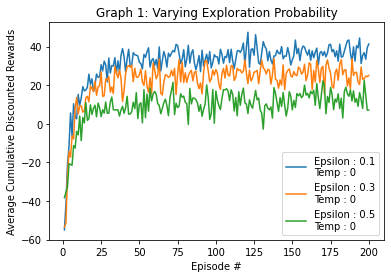

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graph 1
fig = plt.figure()
plt.title("Graph 1: Varying Exploration Probability")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.1,temperature=0)
print("Epsilon : 0.1")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3,temperature=0)
print("Epsilon : 0.3")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.5,temperature=0)
print("Epsilon : 0.5")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='best')
plt.savefig('TestRLmaze_Graph1.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()


---
## Part II.II: Q-Learning Algorithm - Average Cumulative Discounted rewards per episode for different Boltzmann Exploration Temperature. 
---
The execution results below show Graph 2, containing three curves corresponding to Boltzmann Exploration Temperatures T = 0, 10 and 20. Graph 1 uses boltzmann exploration temperature to choose an action with associated boltzman probability.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 0
Q : [[ -3.04670717  -2.92848133  -2.32142808  -2.27674941  -2.74108567
   -2.77070637  -1.590879    -2.27401451  -2.77509663 -71.16818496
   -1.69647856  -2.23900276  -1.42869187  -0.9721023  100.4456047
   61.52688492   0.45653867]
 [  2.20090782   0.66875037   3.84810352   3.08991636  11.13450093
   -3.01231556  -2.04608843  38.80873722  23.29277644 -72.37929042
   69.42755281  59.07384732  -1.13723113  53.96999379   0.
    0.           0.        ]
 [ -3.04433062  -3.07405818  -2.26442078  -2.58540511  -3.0755049
   -3.11993864  -1.98001339  -2.11200665  -2.55134509 -73.43138201
  -68.78849662  -2.355188    -2.34966857   0.           0.
    0.           0.        ]
 [ -3.30526148  -3.02085406  -2.42203125  -2.38320983  -2.76120702
    8.72084754  27.97598906  -2.05528533 -18.20161114 -12.57285761
   -1.05300693  -3.12581352  40.87678648   0.           0.
    0.           0.        ]]
Policy : [1 1 1 1 1 3 3 1 1 3 1 1 3 1 0 0 0]




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 10
Q : [[ 4.82373669e+00  9.15260378e-01 -4.85384084e-01 -6.80210622e-01
   4.25493556e+00  4.96248475e+00 -8.60490703e-01  3.02740539e+00
  -1.32816749e+00 -6.97903988e+01 -9.72507463e+00  1.40749135e+01
   4.75513259e-01  0.00000000e+00  0.00000000e+00  1.32319737e+01
   1.41041317e+00]
 [ 1.37147015e+01  2.11389352e+00  6.67081455e+00  1.16496622e+00
   2.74841559e+01 -1.12112624e+01  3.17629964e+01  4.76343892e+00
   3.98864568e+01 -1.29279491e+01  7.57240247e+01  1.80622860e+01
  -3.89021004e-01  1.66703963e+00  1.01461260e+02  1.16325644e+01
   1.45164914e+00]
 [ 8.03023405e+00  4.45667259e+00 -5.74904794e-02  4.77683614e-01
   2.08558080e+01  1.08223818e+01  4.30128753e+00  1.03851027e+01
   3.54986820e+01 -5.05766206e+01  5.81027887e+00  2.19112453e+01
  -9.01363777e-01 -1.73965503e+01  0.00000000e+00  5.09497279e+01
   1.42374875e+00]
 [ 3.62419831e+00  8.15688810e-01  1.27603104e+00 -7.69044023e-01
   6.46170325e+00  4.96697027e+00  3.58806526e+00  1.90327817e+0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Temperature : 20
Q : [[  0.8823053    2.69072085   5.79650043  12.13363128   1.30809867
    3.9466554   13.72890498  17.69751198   2.85672468 -69.45436846
   16.31156517  33.41303193  10.43299469 -31.27717391 102.00719507
   -1.39958721   1.97312517]
 [  7.05148969   2.22312364  21.09843456  25.08872156  17.96848534
  -28.49397394  41.39552042  50.7739529   35.17848357 -15.08768648
   65.52315777  71.59845616  53.49245362  56.7693687  102.37733063
   83.46242743   2.00138594]
 [  2.79689251   1.22419049   5.84926138  11.7458771    8.56220159
    1.83964147   9.8007556   25.80498813  20.18061273 -64.12952569
  -42.46667511  41.31638142  40.29448681  24.35494041 102.14664189
   87.39589937   1.96940409]
 [  2.09519063   7.06132241  11.16481652  10.94982093   3.98227119
   15.37504527  33.34012591  23.38521365 -54.09311323 -20.75326294
   61.24510021  63.22345366  62.13971952  73.23418388 101.74880168
   77.61027128   1.97840986]]
Policy : [1 3 1 2 1 3 1 0 1 3 3 1 3 3 2 2 2]




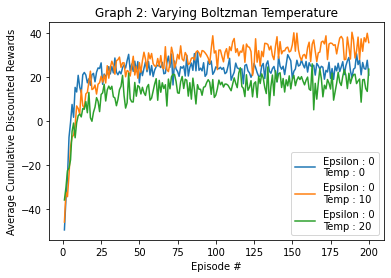

<Figure size 432x288 with 0 Axes>

In [16]:
# Graph 2
fig = plt.figure()
plt.title("Graph 2: Varying Boltzman Temperature")
plt.xlabel("Episode #")
plt.ylabel("Average Cumulative Discounted Rewards")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=0)
print("Temperature : 0")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=10)
print("Temperature : 10")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
[Q,policy] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0,temperature=20)
print("Temperature : 20")
print("Q : " + str(Q))
print("Policy : " + str(policy))
print("\n")
plt.legend(loc='best')
plt.savefig('TestRLmaze_Graph2.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()


---
## Part II.III: Q-Learning Algorithm - Discussion
---
From Graph 1, we see that increasing the exploration probability reduces the average cumulative discounted rewards. We also observe that with increased exploration probability - exploitation of known best action reduces. This results in reducing discounted rewards, and reducing convergence of Q-values and policy. 

And from Graph 2, we see that increasing the boltzman temperature also reduces the average cumulative discounted rewards. Increasing boltzmann temperature also reduces exploitation of of known best action reduces. This results in reducing discounted rewards, and reducing convergence of Q-values and policy. 